## using specific  augmentation method

In [646]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import torch
from scipy.signal import stft
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import re
from torch.optim.lr_scheduler import ExponentialLR,StepLR,CosineAnnealingLR
import scipy.signal as signal
import pywt
import random
from scipy.signal import butter, filtfilt, detrend, lfilter
import gc
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

## load data

### waveform

In [647]:
accdata_sim = np.load('./accwf15_combined_kumamoto_sim_yue.npy')
accdata_bb = np.load('./accwf15_combined_kumamoto_bb_yue.npy')

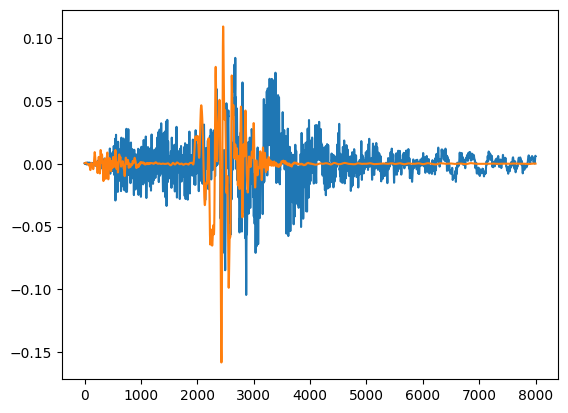

In [648]:
# plt.plot(accdata_sim[2,:,1])
plt.plot(accdata_bb[16,:,1]/100)
plt.plot(accdata_sim[16,:,1])

In [649]:
accdata_bb.shape

(71, 8000, 3)

## perform filter and downsample

In [650]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Get the shape of downsampled_data
num_samples, length, num_channels = accdata_bb.shape

# Initialize an array to store the filtered data
filtered_databb = np.zeros_like(accdata_bb)

# filtered_data3 = np.zeros_like(noisy_data1)
# Sampling interval
dt = 0.01
sampling_rate = 1 / dt

# Design a 4th-order Butterworth low-pass filter with a cutoff of 1.5 Hz
cutoff_freq = 0.50 # Cutoff frequency in Hz

# cutoff_freq2 = 1  # Cutoff frequency in Hz

nyquist_freq = 0.5 * sampling_rate  # Nyquist frequency

normalized_cutoff = cutoff_freq / nyquist_freq

# normalized_cutoff2 = cutoff_freq2 / nyquist_freq

b, a = butter(N=4, Wn=normalized_cutoff, btype='low', analog=False)
# b1, a1 = butter(N=4, Wn=normalized_cutoff1, btype='low', analog=False)
# b2, a2 = butter(N=4, Wn=normalized_cutoff2, btype='low', analog=False)
# Apply the filter to each slice of the data
for i in range(num_samples):
    for j in range(num_channels):
        filtered_databb[i, :, j] = lfilter(b, a, accdata_bb[i, :, j])
        # filtered_data2[i, :, j] = filtfilt(b1, a1, noisy_data1[i, :, j])
        # filtered_data3[i, :, j] = filtfilt(b2, a2, noisy_data1[i, :, j])



In [651]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Get the shape of downsampled_data
num_samples, length, num_channels = accdata_sim.shape

# Initialize an array to store the filtered data
filtered_data = np.zeros_like(accdata_sim)

# filtered_data3 = np.zeros_like(noisy_data1)
# Sampling interval
dt = 0.01
sampling_rate = 1 / dt

# Design a 4th-order Butterworth low-pass filter with a cutoff of 1.5 Hz
cutoff_freq = 0.5  # Cutoff frequency in Hz

# cutoff_freq2 = 1  # Cutoff frequency in Hz

nyquist_freq = 0.5 * sampling_rate  # Nyquist frequency

normalized_cutoff = cutoff_freq / nyquist_freq

# normalized_cutoff2 = cutoff_freq2 / nyquist_freq

b, a = butter(N=4, Wn=normalized_cutoff, btype='low', analog=False)
# b1, a1 = butter(N=4, Wn=normalized_cutoff1, btype='low', analog=False)
# b2, a2 = butter(N=4, Wn=normalized_cutoff2, btype='low', analog=False)
# Apply the filter to each slice of the data
for i in range(num_samples):
    for j in range(num_channels):
        filtered_data[i, :, j] = lfilter(b, a, accdata_sim[i, :, j])
        # filtered_data2[i, :, j] = filtfilt(b1, a1, noisy_data1[i, :, j])
        # filtered_data3[i, :, j] = filtfilt(b2, a2, noisy_data1[i, :, j])



In [652]:
# Downsample the signal from 100 Hz to 10 Hz
downsample_factor = 10
downsampled_data = filtered_data[:, ::downsample_factor]*100
downsampled_databb = filtered_databb[:, ::downsample_factor]

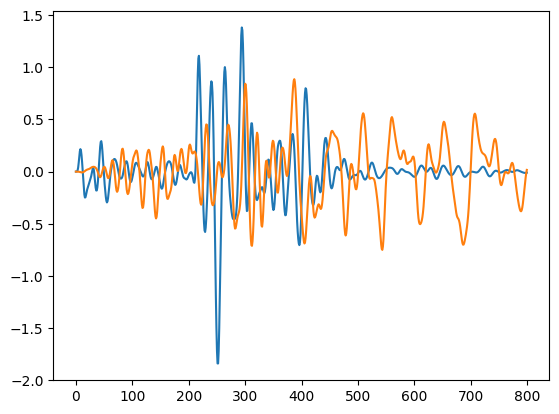

In [653]:
# plt.plot(filtered_data[0,:,2])
id = 12
ic = 2
plt.plot(downsampled_data[id,:,ic])
plt.plot(downsampled_databb[id,:,ic])

In [654]:
# predictions[id,0,ic],y_test[id,0,ic]

In [655]:
T = np.concatenate( (np.arange(0.05, 0.1, 0.05) , np.arange (0.1, 1, 0.1)  , np.arange (1, 15.25, 0.25) ) ) # Time vector for the spectral response
T = np.concatenate((np.array([0]), T))

In [656]:
downsampled_data.shape

(71, 800, 3)

In [657]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [658]:

# remaining 10% for test set
downsample_data_10 = downsampled_databb

In [659]:
downsample_data_10.shape

(71, 800, 3)

In [660]:
# perform STFT to all data
# Example data dimensions
num_events ,time_points ,num_channels = downsample_data_10.shape


# Define STFT parameters
sample_rate = 10  # Hz
nperseg = 50  # Length of each segment
noverlap = 35  # Number of points to overlap between segments
nfft = 100  # Number of points in the FFT

# Initialize array to store STFT results
X_low_freq_test = np.zeros((num_events,  11, 55, num_channels), dtype=np.float64)


# Perform STFT for each event
for event_idx in range(num_events):
    for channel_idx in range(num_channels):
        _, _, Zxx = stft(downsample_data_10[event_idx, :, channel_idx], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        X_low_freq_test[event_idx, :, :, channel_idx] = np.abs(Zxx)[0:11,:]

# Verify the shape of stft_results
print("Shape of STFT results for test:", X_low_freq_test.shape)

Shape of STFT results for test: (71, 11, 55, 3)


In [661]:
f_stft,t_stft,Zxx = stft(downsample_data_10[event_idx, :, channel_idx], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

### metadata

In [662]:
metadata = pd.read_csv('./filtered_data_kumamoto.csv',low_memory=False)

In [663]:
print(metadata.columns)

Index(['station', 'SA_Vx', 'SA_Vy', 'SA_Vz', 'file_name', 'P_times', 'S_times',
       'event time', 'event latitude', 'event longitude', 'event depth',
       'event mag', 'station latitude', 'station longitude', 'PGA(gal)',
       'PGAEW2(gal)', 'PGANS2(gal)', 'PGAUD2(gal)', 'SAEW2(gal)', 'SANS2(gal)',
       'SAUD2(gal)', 'PGA1hz(gal)', 'PGA1hzH(gal)', 'PGA1hEW2(gal)',
       'PGA1hNS2(gal)', 'PGA1hUD2(gal)', 'Code', 'MT_Magnitude_',
       'JMA_Magnitude_', 'repi_1', 'Mo_', 'rjb_0', 'rjb_1', 'Vs30', 'Ztor_0',
       'Ztor_1', 'Rake_', 'Dip_', 'Strike_', 'Tectonic_Zhoa_', 'Latitude_',
       'Longitude_', 'MT_Depth_', 'stationLat', 'stationLon', 'timestamp',
       'prefix', 'event_number', 'label', 'pred_pgaEW2'],
      dtype='object')


In [664]:
metadata['log10_PGAEW2'] = np.log10(metadata['PGAEW2(gal)'].values)
metadata[['station longitude', 'station latitude', 'log10_PGAEW2']].to_csv('true_pga_EW_kumamoto.txt', sep=' ', header=False, index=False)

metadata['log10_PGAUD2'] = np.log10(metadata['PGAUD2(gal)'].values)
metadata[['station longitude', 'station latitude', 'log10_PGAUD2']].to_csv('true_pga_UD_kumamoto.txt', sep=' ', header=False, index=False)


### preprocess data

In [665]:
T = np.concatenate( (np.arange(0.05, 0.1, 0.05) , np.arange (0.1, 1, 0.1)  , np.arange (1, 15.25, 0.25) ) ) # Time vector for the spectral response
T = np.concatenate((np.array([0]), T))

In [666]:
X_meta = metadata[['PGAEW2(gal)', 'PGANS2(gal)','PGAUD2(gal)', 
                   'SAEW2(gal)', 'SANS2(gal)', 'SAUD2(gal)',
                  ]].values
X_meta_sim= metadata[['PGAEW2(gal)', 'PGANS2(gal)','PGAUD2(gal)', 
                   'SA_Vx', 'SA_Vy', 'SA_Vz'
                  ]].values
X_meta2 = metadata[['Vs30','JMA_Magnitude_','repi_1']].values

In [667]:
X_meta2

array([[1421.05263158,    7.3       ,   84.45404254],
       [ 303.14560521,    7.3       ,  224.2835129 ],
       [ 865.38461538,    7.3       ,   77.32646474],
       [ 251.1627907 ,    7.3       ,  117.7234972 ],
       [ 557.8888265 ,    7.3       ,  100.0596071 ],
       [ 847.45508982,    7.3       ,   91.61766128],
       [ 836.90946256,    7.3       ,  105.1532922 ],
       [ 248.27586207,    7.3       ,   13.38250264],
       [ 280.44412607,    7.3       ,  108.7778558 ],
       [ 629.47635495,    7.3       ,  185.9496615 ],
       [1000.        ,    7.3       ,   77.57269359],
       [ 566.74535119,    7.3       ,  123.5257424 ],
       [ 254.87804878,    7.3       ,  172.6588228 ],
       [ 477.45204507,    7.3       ,  101.5174734 ],
       [ 634.49023861,    7.3       ,   98.02263307],
       [ 921.3362069 ,    7.3       ,   59.65792317],
       [ 755.55555556,    7.3       ,  172.4247347 ],
       [1387.66519824,    7.3       ,  161.9566445 ],
       [ 602.97029703,    7.

In [668]:
np.mean(X_meta2[2])

316.67036004153846

In [669]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
# 初始化 StandardScaler
with open('/data_array1/panyx/ANN_GMPE/resnet_20240903/training/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 对数据进行标准化
X_meta2 = scaler.transform(X_meta2)
X_meta2 = np.repeat(X_meta2[:, :, np.newaxis], 3, axis=2)
# # normalized_data 现在是均值为 0，方差为 1 的数据
print(X_meta2.mean(axis=0))  # 每列的均值接近 0
print(X_meta2.std(axis=0))   # 每列的标准差接近 1

[[ 0.52982147  0.52982147  0.52982147]
 [ 2.7131756   2.7131756   2.7131756 ]
 [-0.54814397 -0.54814397 -0.54814397]]
[[1.23413816e+00 1.23413816e+00 1.23413816e+00]
 [3.10862447e-15 3.10862447e-15 3.10862447e-15]
 [1.25366436e+00 1.25366436e+00 1.25366436e+00]]


In [670]:
# Vs30 = metadata[['Vs30']].values

# M = 7*np.ones((Vs30.shape[0], 1))
# dist2 = dist.to_numpy().reshape(Vs30.shape[0], 1)

# X_meta2 = np.concatenate((Vs30, M, dist2), axis=1)

In [671]:
X_meta2.shape

(71, 3, 3)

In [672]:
# 假设 X_meta 的形状为 (14786, 6)
X_meta_converted = np.empty_like(X_meta, dtype=object)  # 创建与 X_meta 相同形状的空数组

# 遍历 X_meta 中的每个元素，检查其类型
for i in range(X_meta.shape[0]):  # 遍历第一维
    for j in range(X_meta.shape[1]):  # 遍历第二维
        item = X_meta[i, j]
        
        # 检查元素是否为字符串
        if isinstance(item, str):
            # 去除方括号并将其转换为数组（如果有空格分隔的数值）
            X_meta_converted[i, j] = np.fromstring(item.strip('[]'), sep=' ')
        else:
            # 如果是浮点数，直接复制
            X_meta_converted[i, j] = item

# 将处理后的结果转换为最终的 numpy 数组
X_meta_converted = np.array(X_meta_converted)

In [673]:
# 假设 X_meta 的形状为 (14786, 6)
X_meta_converted_sim = np.empty_like(X_meta_sim, dtype=object)  # 创建与 X_meta 相同形状的空数组

# 遍历 X_meta 中的每个元素，检查其类型
for i in range(X_meta_sim.shape[0]):  # 遍历第一维
    for j in range(X_meta_sim.shape[1]):  # 遍历第二维
        item = X_meta_sim[i, j]
        
        # 检查元素是否为字符串
        if isinstance(item, str):
            # 去除方括号并将其转换为数组（如果有空格分隔的数值）
            X_meta_converted_sim[i, j] = np.fromstring(item.strip('[]'), sep=' ')
        else:
            # 如果是浮点数，直接复制
            X_meta_converted_sim[i, j] = item

# 将处理后的结果转换为最终的 numpy 数组
X_meta_converted_sim = np.array(X_meta_converted_sim)

In [674]:
# 假设 X_meta 是你的数据，形状为 (14786, 6)
# 提取第 0 列和第 3 列，沿第二个维度拼接
col_0_3 = np.concatenate((X_meta_converted[:, 0].reshape(-1, 1), X_meta_converted[:, 3].reshape(-1, 1)), axis=1)

# 提取第 1 列和第 4 列，沿第二个维度拼接
col_1_4 = np.concatenate((X_meta_converted[:, 1].reshape(-1, 1), X_meta_converted[:, 4].reshape(-1, 1)), axis=1)

# 提取第 2 列
col_2_5 = np.concatenate((X_meta_converted[:, 2].reshape(-1, 1), X_meta_converted[:, 5].reshape(-1, 1)), axis=1)


# 最终拼接为 (14786, 3) 数组
result = np.concatenate((col_0_3, col_1_4, col_2_5), axis=1)



In [675]:
col_0_3_sim = np.concatenate((X_meta_converted_sim[:, 0].reshape(-1, 1), X_meta_converted_sim[:, 3].reshape(-1, 1)), axis=1)

# 提取第 1 列和第 4 列，沿第二个维度拼接
col_1_4_sim = np.concatenate((X_meta_converted_sim[:, 1].reshape(-1, 1), X_meta_converted_sim[:, 4].reshape(-1, 1)), axis=1)

# 提取第 2 列
col_2_5_sim = np.concatenate((X_meta_converted_sim[:, 2].reshape(-1, 1), X_meta_converted_sim[:, 5].reshape(-1, 1)), axis=1)


# 最终拼接为 (14786, 3) 数组
result_sim = np.concatenate((col_0_3_sim, col_1_4_sim, col_2_5_sim), axis=1)

In [676]:
SAEW2 = np.zeros((X_meta_converted.shape[0], 67))
SANS2 = np.zeros((X_meta_converted.shape[0], 67))
SAUD2 = np.zeros((X_meta_converted.shape[0], 67))
for i in range(X_meta_converted.shape[0]):
    SAEW2[i,:]=X_meta_converted[:, 3][i]
    SANS2[i,:]=X_meta_converted[:, 4][i]
    SAUD2[i,:]=X_meta_converted[:, 5][i]
    

In [677]:
SAEW2_sim = np.zeros((X_meta_converted_sim.shape[0], 67))
SANS2_sim = np.zeros((X_meta_converted_sim.shape[0], 67))
SAUD2_sim = np.zeros((X_meta_converted_sim.shape[0], 67))
for i in range(X_meta_converted_sim.shape[0]):
    SAEW2_sim[i,:]=X_meta_converted_sim[:, 3][i]
    SANS2_sim[i,:]=X_meta_converted_sim[:, 4][i]
    SAUD2_sim[i,:]=X_meta_converted_sim[:, 5][i]

In [678]:
col_0_3 = np.concatenate((X_meta_converted[:, 0].reshape(-1, 1), SAEW2 ), axis=1)

# 提取第 1 列和第 4 列，沿第二个维度拼接
col_1_4 = np.concatenate((X_meta_converted[:, 1].reshape(-1, 1), SANS2), axis=1)

# 提取第 2 列
col_2_5 = np.concatenate((X_meta_converted[:, 2].reshape(-1, 1), SAUD2), axis=1)



result = np.stack((col_0_3, col_1_4, col_2_5), axis=2)


In [679]:
col_0_3_sim = np.concatenate((X_meta_converted_sim[:, 0].reshape(-1, 1), SAEW2_sim ), axis=1)

# 提取第 1 列和第 4 列，沿第二个维度拼接
col_1_4_sim = np.concatenate((X_meta_converted_sim[:, 1].reshape(-1, 1), SANS2_sim), axis=1)

# 提取第 2 列
col_2_5_sim = np.concatenate((X_meta_converted_sim[:, 2].reshape(-1, 1), SAUD2_sim), axis=1)



result_sim = np.stack((col_0_3_sim, col_1_4_sim, col_2_5_sim), axis=2)


In [680]:
result.shape,result_sim.shape,

((71, 68, 3), (71, 68, 3))

In [681]:
result = np.array(result, dtype=float)
result_sim = np.array(result_sim, dtype=float)

In [682]:
T = np.concatenate( (np.arange(0.05, 0.1, 0.05) , np.arange (0.1, 1, 0.1)  , np.arange (1, 15.25, 0.25) ) ) # Time vector for the spectral response
T = np.concatenate((np.array([0]), T))

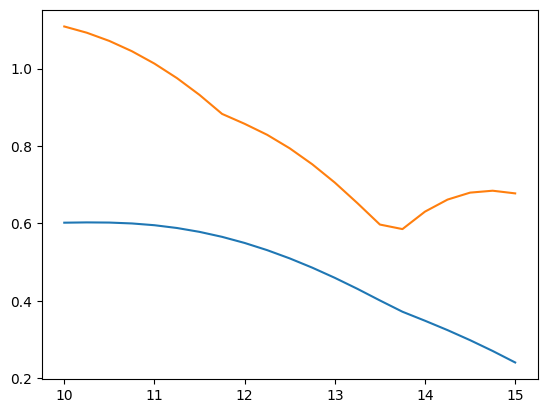

In [683]:
id=10
ic=0
plt.plot(T[47:],np.log(result_sim[id,47:,ic]*100))
plt.plot(T[47:],np.log(result[id,47:,ic]))
# plt.plot(T[20:],np.log(result_sim[id,20:,ic]*100))

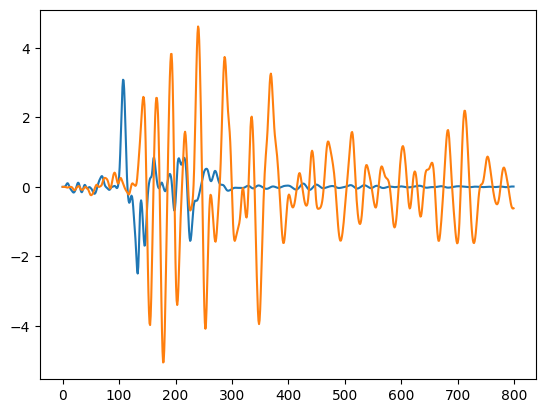

In [684]:

plt.plot(downsampled_data[id,:,ic])
plt.plot(downsampled_databb[id,:,ic])

In [685]:
# X_meta = metadata[['Mo_','rjb_0','Vs30','Rake_','MT_Depth_','PGA1hz(gal)','PGV1hz(cm/s)',
#                    'PGA1hEW2(gal)', 'PGA1hNS2(gal)','PGA1hUD2(gal)',
#                    'PGV1hzEW2(cm/s)', 'PGV1hzNS2(cm/s)', 'PGV1hzUD2(cm/s)']].values

# X_meta = metadata[['PGA1hEW2(gal)', 'PGA1hNS2(gal)','PGA1hUD2(gal)', 
#                    'SAEW2(gal)', 'SANS2(gal)', 'SAUD2(gal)',
#                   ]].values

# X_meta = metadata[['JMA_Magnitude_','repi_1','Vs30','Rake_','MT_Depth_','PGA1hz(gal)',]].values
# X_meta = metadata[[ 'PGA1hz(gal)','PGV1hz(cm/s)']].values
# X_meta[:,0]=(0.923)*(X_meta[:,0])+0.37

# X_meta[:,-1]=np.log(X_meta[:,-1])
# X_meta[:,-2]=np.log(X_meta[:,-2])
# X_meta[:,-3]=np.log(X_meta[:,-3])
# X_meta[:,-4]=np.log(X_meta[:,-4])
# X_meta[:,-5]=np.log(X_meta[:,-5])
# X_meta[:,-6]=np.log(X_meta[:,-6])
# X_meta[:,-1]=np.log(X_meta[:,-1].astype(np.float64))

# X_meta =  np.log(result[:,12:,:].astype(np.float64))
X_meta =np.log(result[:,15:,:]).astype(np.float64)
X_meta_sim =np.log(result_sim[:,15:,:]*100).astype(np.float64)

X_meta = np.concatenate((X_meta, X_meta2.astype(np.float64)), axis=1)
X_meta_sim  = np.concatenate((X_meta_sim , X_meta2.astype(np.float64)), axis=1)


# y = metadata[['PGA(gal)','PGV(cm/s)']].values
# y = metadata[['PGAEW2(gal)', 'PGANS2(gal)','PGAUD2(gal)']].values
y = np.log(result[:,:15,:]).astype(np.float64)
# y[:,0]=np.log(y[:,0].astype(np.float64))
# y[:,1]=np.log(y[:,1].astype(np.float64))
# y[:,2]=np.log(y[:,2].astype(np.float64))
#y[:,0]=y[:,0].astype(np.float64)
#y[:,1]=y[:,1].astype(np.float64)
#y[:,2]=y[:,2].astype(np.float64)

In [686]:
X_meta.shape

(71, 56, 3)

In [687]:
y.shape,X_meta[:,:12,:].shape,X_meta[:,12:,:].shape

((71, 15, 3), (71, 12, 3), (71, 44, 3))

In [688]:
X_meta_max = np.max(X_meta, axis=(1, 2,), keepdims=True)
# X_meta /= X_meta_max

In [689]:
X_meta.shape,X_meta_max.shape

((71, 56, 3), (71, 1, 1))

In [690]:
# X_meta[:,0] = X_meta[:,0] / np.max(X_meta[:,0])
# X_meta[:,1] = X_meta[:,1] / np.max(X_meta[:,1])
# X_meta[:,2] = X_meta[:,2] / np.max(X_meta[:,2])
# X_meta[:,3] = X_meta[:,3] / np.max(X_meta[:,3])
# X_meta[:,4] = X_meta[:,4] / np.max(X_meta[:,4])
# for PGA and PGV
# X_meta[:,-2] = X_meta[:,-2] / np.max(X_meta[:,-2])
# X_meta[:,-1] = X_meta[:,-1] / np.max(X_meta[:,-1])

In [691]:
# X_meta_test  =X_meta_sim
X_meta_test  =X_meta_sim
wf_test  = np.concatenate((downsample_data_10,), axis=0)
y_test = y

In [692]:
# X_meta_train[:,-2]=np.log(pga)
# X_meta_valid [:,-2]=np.log(pga_valid)

### normalization

In [693]:

X_low_freq_test_0_2 = np.max(X_low_freq_test, axis=(1, 2, 3), keepdims=True)
wf_test_0_2 = np.max(wf_test, axis=(1, 2, ), keepdims=True)
# X_low_freq_test_3_6 = np.max(X_low_freq_test[:, :, :, 3:6], axis=(1, 2, 3), keepdims=True)


X_low_freq_test /= X_low_freq_test_0_2
wf_test /= wf_test_0_2
# X_low_freq_test[:, :, :, 3:6] /= X_low_freq_test_3_6

In [694]:
X_low_freq_test = torch.tensor(X_low_freq_test, dtype=torch.float32)
X_meta_test = torch.tensor(X_meta_test, dtype=torch.float32)
wf_test = torch.tensor(wf_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## model

In [695]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import re
from torch.optim.lr_scheduler import ExponentialLR,StepLR,CosineAnnealingLR
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1,dropout_prob=0.8):
        super(ResidualBlock1d, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        # self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.stride = stride
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Adjusting dimensions if stride is not 1
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.leaky_relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        identity = self.downsample(identity)
        
        out += identity
        out = F.leaky_relu(out)
        
        return out

class ResNet1D(nn.Module):
    def __init__(self):
        super(ResNet1D, self).__init__()
        # self.in_channels = 6
        self.conv1 = nn.Conv1d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer2 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 128, blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 64, blocks=2, stride=2)

        
        self.avgpool = nn.AdaptiveAvgPool1d(3)
        # self.fc = nn.Linear(256, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock1d(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1d(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.maxpool(x)
        #print(x.shape)

        x = self.layer1(x)
        #print(x.shape)

        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        x = self.layer4(x)
        #print(x.shape)

        x = self.avgpool(x)
        #print(x.shape)
        # x = torch.flatten(x, 1)
        # print(x.shape)
        # x = self.fc(x)
        # print(x.shape)
        self.fc_output = x
        return x

# # Example usage
# model_wf = ResNet1D()
# model_freq = ResNet1D()




class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, dropout_prob=0.8):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout_prob)

        # Adjusting dimensions if stride is not 1
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.leaky_relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks=[3, 3, 3, 3, 3], dropout_prob=0.8):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels after first convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(128, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(256, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(256, num_blocks[3], stride=1)
        self.layer5 = self._make_layer(256, num_blocks[3], stride=1)
        self.layer6 = self._make_layer(256, num_blocks[3], stride=1)
        self.layer7 = self._make_layer(64, num_blocks[3], stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 3))

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride=stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)  # (batch_size, 101, 81, 3) -> (batch_size, 3, 101, 81)
        # print(x.shape)
        # print(f"Input size: {x.size()}")

        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        # print(f"After pool1: {x.size()}")

        x = self.layer1(x)
        #print(f"After layer1: {x.size()}")

        x = self.layer2(x)
        #print(f"After layer2: {x.size()}")

        x = self.layer3(x)
        #print(f"After layer3: {x.size()}")

        x = self.layer4(x)
        #print(f"After layer4: {x.size()}")

        x = self.layer5(x)
        # print(f"After layer5: {x.size()}")
        x = self.layer6(x)
        x = self.layer7(x)
        #print(f"After avgpool: {x.size()}")
        x = self.avgpool(x).squeeze(2)
        # print(f"After avgpool: {x.size()}")

        # x = x.view(x.size(0), -1)
        # print(f"Flattened size: {x.size()}")

        self.fc_output = x
        return x


import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, model, model_wf, dim_meta):
        super(CombinedModel, self).__init__()
        self.model_wf = model_wf
        self.cnn_lstm_model = model
        cnn_output_size = model.fc_output.size(1)  # Get the size of CNN output
        
        # Define Conv1D and batch normalization layers for meta data
        self.conv1_meta = nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2_meta = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3_meta = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=2, bias=False)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4_meta = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.bn4 = nn.BatchNorm1d(64)
        self.conv5_meta = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=2, bias=False)
        self.bn5 = nn.BatchNorm1d(32)
        self.conv6_meta = nn.Conv1d(32, 3, kernel_size=3, stride=1, padding=2, bias=False)
        
        self.avgpool_meta = nn.AdaptiveAvgPool1d((12, ))

        # Dropout and fully connected layers
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(64 + 64 + 12, 64)
        # conv1_final = nn.Conv1d(in_channels=64 + 64 + 12, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 + 64 + 12 + 3, 64)
        self.fc2 = nn.Linear(64, 15)
        # self.fc3 = nn.Linear(64, 32)
        # self.fc4 = nn.Linear(32, 28)
       

        # Batch normalization layers
        # self.bn1 = nn.BatchNorm1d(512)
        # self.bn2 = nn.BatchNorm1d(256)
        # self.bn3 = nn.BatchNorm1d(128)
        # self.bn4 = nn.BatchNorm1d(32)
    
        # # Define fully connected layers
        # self.fc1 = nn.Linear(cnn_output_size + 64, 16)
        # self.fc2 = nn.Linear(16, 3)
        # # # self.fc3 = nn.Linear(256, 128)
        # # # self.fc4 = nn.Linear(128, 32)
        # self.fc2 = nn.Linear(6, 3)
        
    def forward(self, low_freq_data, wf_data , meta_data, ):
        
        wf_output =  self.model_wf(wf_data).permute(0, 2, 1)
        cnn_output = self.cnn_lstm_model(low_freq_data).permute(0, 2, 1)
        
        # meta_data_max = meta_data_max.view(meta_data_max.size(0), -1)
        
        meta_x = meta_data[:,:-3,:].permute(0, 2, 1)
        meta_x = F.leaky_relu(self.bn1(self.conv1_meta(meta_x)))
        meta_x = self.dropout(meta_x)
        meta_x = F.leaky_relu(self.bn2(self.conv2_meta(meta_x)))
        meta_x = self.dropout(meta_x)
        meta_x = F.leaky_relu(self.bn3(self.conv3_meta(meta_x)))
        meta_x = self.dropout(meta_x)
        meta_x = F.leaky_relu(self.bn4(self.conv4_meta(meta_x)))
        meta_x = self.dropout(meta_x)
        meta_x = F.leaky_relu(self.bn5(self.conv5_meta(meta_x)))
        meta_x = self.dropout(meta_x)
        meta_x = F.leaky_relu(self.conv6_meta(meta_x))
        meta_x = self.avgpool_meta(meta_x)
        # print(f"wf_output: {wf_output.size()}")
        # print(f"wf_output: {cnn_output.size()}")
        # print(f"wf_output: {meta_x.size()}")
        # print(f"meta_data: {meta_data[:,1,:].unsqueeze(-1).size()}")
        
        combined = torch.cat((wf_output, cnn_output, meta_x, meta_data[:,-3:,:].permute(0, 2, 1)), dim=2)
        x = F.leaky_relu(self.fc1(combined))
        x = self.fc2(x)






        return x.permute(0, 2, 1)


        


In [696]:
# import model_3Copy1Copy1Copy1Copy1Copy1Copy1Copy1
resnet_model = ResNet()
# Generate random input tensor for testing
input_tensor = torch.randn(2, 11, 55, 3)  # (batch_size, height, width, channels)

# Forward pass to see output sizes
output = resnet_model(input_tensor)
print(f'Final output size: {output.size()}')


Final output size: torch.Size([2, 64, 3])


In [697]:
# import model_3Copy1Copy1Copy1Copy1Copy1Copy1Copy1
wf_model = ResNet1D()
# Generate random input tensor for testing
input_tensor = torch.randn(2, 800, 3)  # (batch_size, height, width, channels)

# Forward pass to see output sizes
output = wf_model(input_tensor)
print(f'Final output size: {output.size()}')


Final output size: torch.Size([2, 64, 3])


In [698]:
combined_model = CombinedModel(resnet_model,wf_model, 21)

In [699]:
# weights = torch.load('best_model_allmeta_3comp_mse_sgd.pth')

# weights = torch.load('../compare_dataaugment/best_model_05_noagu.pth')
weights = torch.load('../compare_lowpassfreq/best_model_05.pth')
# weights = torch.load('../compare_dataaugment/best_model_05_noaguall.pth')
new_weights = {}
for k, v in weights.items():
    if k.startswith('module.'):
        new_weights[k[7:]] = v
    else:
        new_weights[k] = v


In [700]:
# Load the saved model state dictionary
combined_model.load_state_dict(new_weights)

# Set the model to evaluation mode (this is important for certain layers like dropout and batchnorm)
combined_model.eval()



CombinedModel(
  (model_wf): ResNet1D(
    (conv1): Conv1d(3, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock1d(
        (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.8, inplace=False)
        (downsample): Sequential(
          (0): Conv1d(64, 128, kernel_size=(1,), stride=(2,), bias=False)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [701]:
X_low_freq_test.shape

torch.Size([71, 11, 55, 3])

In [702]:
# Assuming combined_model, X_low_freq_test, X_meta_test are defined

# 1. Set model to evaluation mode
combined_model.eval()

# 2. Move test data to CPU if they were previously on GPU (assuming they are already tensors)

# 3. Forward pass to get predictions

with torch.no_grad():
    outputs_test = combined_model(X_low_freq_test,wf_test, X_meta_test,)
    # outputs_valid = combined_model(X_low_freq_valid, X_meta_test,wf_valid)

# 4. Post-process predictions (assuming regression, adjust as needed)
predictions = outputs_test.squeeze().numpy()

# Now predictions are on CPU and can be used as needed


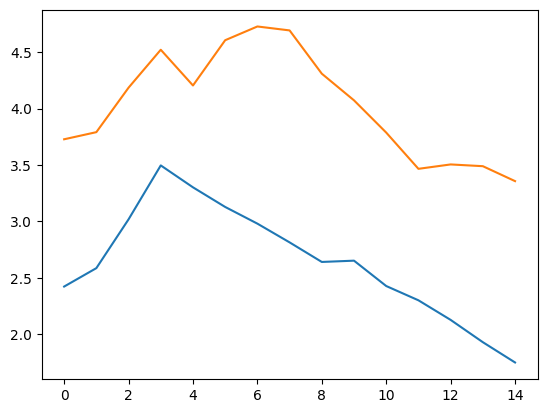

In [703]:
plt.plot(predictions[3,:,1])
plt.plot(  y_test[3,:,1])

In [704]:
dist = metadata[['rjb_1']].values
rjb = metadata[['rjb_1']].values

In [705]:
indices = np.where(dist < 200)[0]

In [706]:
predictions.shape

(71, 15, 3)

In [707]:
y_test.shape

torch.Size([71, 15, 3])

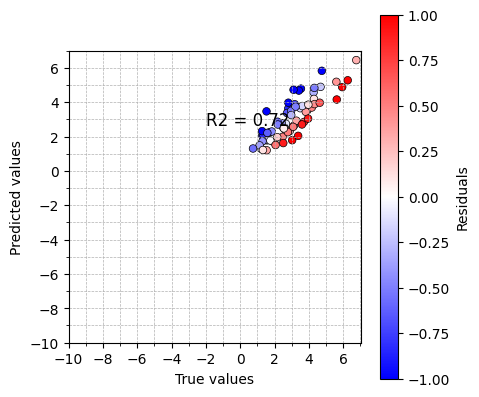

In [708]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming you already have defined y_test, predictions, and residuals as per your example
ind = 2
# Assuming you already have defined y_test, predictions, and residuals as per your example
y_testcpu = y_test[indices,0,ind]
prediction_xgb = predictions[indices,0,ind]
r2 = r2_score(y_testcpu, prediction_xgb)

# Calculate residuals (errors)
residuals = y_testcpu.squeeze() - prediction_xgb

# Set up colors based on residuals (using the 'coolwarm' colormap with increased brightness)
norm = plt.Normalize(-1, 1)  # Normalize colors from -4 to 4
cmap = plt.cm.bwr  # Choose 'coolwarm' colormap for residuals

plt.figure(figsize=(12/2.54, 12/2.54))
scatter = plt.scatter(y_testcpu.squeeze(), prediction_xgb, c=residuals, cmap=cmap, s=30, norm=norm, edgecolors='k', linewidths=0.5, alpha=1)  # Plot with color mapped to residuals

cbar = plt.colorbar(scatter, label='Residuals')  # Add color bar showing the range of residuals
cbar.ax.tick_params(labelsize=10)  # Adjust color bar tick size for readability

# plt.plot([-6, 5], [-6, 5], color='k', linestyle='--', linewidth=0.6)  # Plot thin y=x line

plt.xlabel('True values')
plt.ylabel('Predicted values')

# Add R2 score as a label on the plot
plt.text(-2, 3.5, f'R2 = {r2:.2f}', fontsize=12, color='black', ha='left', va='top')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().set_aspect('equal')

major_ticks = np.arange(-10, 8, 2)  # Major ticks from -10 to 5 with step 2
minor_ticks = np.arange(-10, 8, 1)  # Minor ticks from -10 to 5 with step 1

plt.gca().set_xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
plt.gca().set_yticks(major_ticks)
plt.gca().set_yticks(minor_ticks, minor=True)
# plt.xlim([-7, 4])
# plt.ylim([-7, 4])

# plt.savefig('R2_resnet.png', dpi=300, bbox_inches='tight')

plt.show()


In [709]:
from scipy.io import loadmat
data = loadmat('CY14_results_kumamoto.mat')

# Access the variables
medianvec = data['medianvec']
sigma = data['sigma']

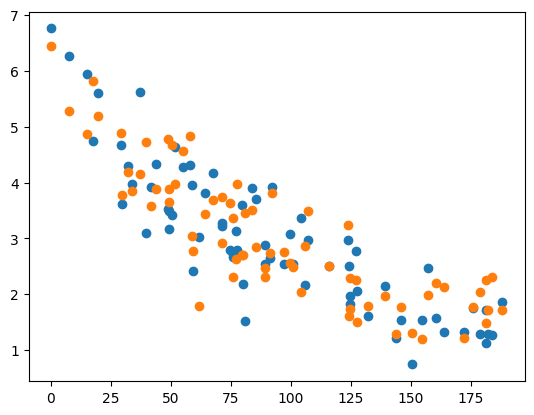

In [710]:
plt.scatter(dist[indices],y_test[indices,0,ind])
plt.scatter(dist[indices],predictions[indices,0,ind])

In [711]:
metadata.columns

Index(['station', 'SA_Vx', 'SA_Vy', 'SA_Vz', 'file_name', 'P_times', 'S_times',
       'event time', 'event latitude', 'event longitude', 'event depth',
       'event mag', 'station latitude', 'station longitude', 'PGA(gal)',
       'PGAEW2(gal)', 'PGANS2(gal)', 'PGAUD2(gal)', 'SAEW2(gal)', 'SANS2(gal)',
       'SAUD2(gal)', 'PGA1hz(gal)', 'PGA1hzH(gal)', 'PGA1hEW2(gal)',
       'PGA1hNS2(gal)', 'PGA1hUD2(gal)', 'Code', 'MT_Magnitude_',
       'JMA_Magnitude_', 'repi_1', 'Mo_', 'rjb_0', 'rjb_1', 'Vs30', 'Ztor_0',
       'Ztor_1', 'Rake_', 'Dip_', 'Strike_', 'Tectonic_Zhoa_', 'Latitude_',
       'Longitude_', 'MT_Depth_', 'stationLat', 'stationLon', 'timestamp',
       'prefix', 'event_number', 'label', 'pred_pgaEW2', 'log10_PGAEW2',
       'log10_PGAUD2'],
      dtype='object')

In [712]:
data_plot = metadata[['station longitude', 'station latitude', 'PGAEW2(gal)', 'PGANS2(gal)', 'PGAUD2(gal)',]].values

In [713]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [714]:
# np.savetxt('true_pga_kumamoto.txt', data_truepga, fmt='%.6f', delimiter=' ', newline='\n')

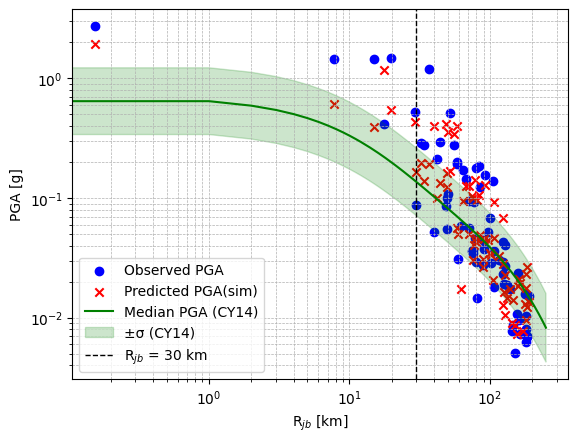

In [715]:
# Calculate upper and lower bounds for medianvec based on sigma
upper_bound = medianvec[10] * np.exp(sigma[10])
lower_bound = medianvec[10] * np.exp(-sigma[10])

# Plot observed data
plt.scatter(rjb[indices], np.sqrt(np.exp(y_test[indices,0,ind])**2+np.exp(y_test[indices,1,ind])**2+np.exp(y_test[indices,2,ind])**2) / (9.8 * 1e2), label='Observed PGA', color='blue', marker='o')

# Plot predicted data
plt.scatter(rjb[indices],  np.sqrt(np.exp(predictions[indices,0,ind])**2+np.exp(predictions[indices,1,ind])**2+np.exp(predictions[indices,2,ind])**2) / (9.8 * 1e2), label='Predicted PGA(sim)', color='red', marker='x')

# Plot median PGA values from CY14 with ±σ shaded area
plt.plot(np.linspace(0,250,250), medianvec[10, :], label='Median PGA (CY14)', color='green', linestyle='-')
plt.fill_between(np.linspace(0,250,250), lower_bound, upper_bound, color='green', alpha=0.2, label='±σ (CY14)')
plt.axvline(x=30, color='black', linestyle='--', linewidth=1, label='R$_{jb}$ = 30 km')
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and legend
plt.xlabel('R$_{jb}$ [km]')
plt.ylabel('PGA [g]')
# plt.title('Observed vs Predicted vs CY14 Median PGA')
# plt.xlim([0.1,130])
# plt.ylim([0.001,2])
plt.legend()
# Show plot with grid
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
# plt.savefig('kumamoto_noaguall.png',dpi=300)
# plt.savefig('kumamoto_noaguall.pdf')
# plt.savefig('kumamoto_noaguall.png',dpi=300)
# plt.savefig('kumamoto_noaguall.pdf')
# np.savetxt('y_test_05Hz.txt',  np.exp(predictions[indices,0,ind]))
# np.savetxt('Rjb_index.txt', rjb[indices] )
# np.savetxt('y_test_true.txt', np.exp(y_test[indices,0,ind]))
plt.show()

In [716]:
metadatasim = pd.read_csv('./filtered_data_kumamoto_yue.csv',low_memory=False)

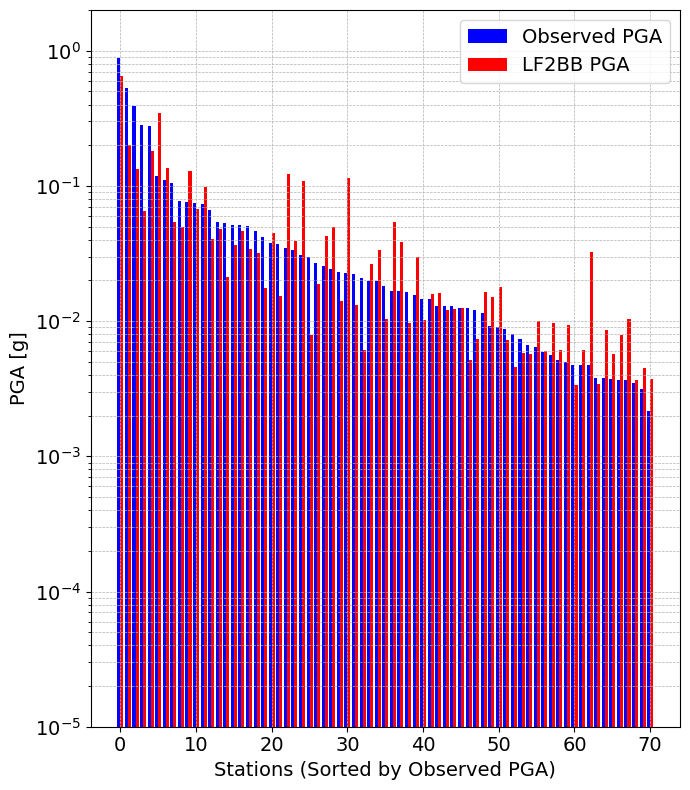

In [717]:
upper_bound = medianvec[10] * np.exp(sigma[10])
lower_bound = medianvec[10] * np.exp(-sigma[10])

# Observed and predicted PGA values
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = np.exp(predictions[indices, 0, ind]) / (9.8 * 1e2)

# Combine Rjb and PGA values for sorting
combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T

# Sort by observed PGA values in descending order
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

# Extract sorted values
sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

# Set figure size
plt.figure(figsize=(7, 8))    # Adjust size as needed (width, height)

# Create bar chart
x = np.arange(len(sorted_rjb))  # Index for bars
plt.bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
plt.bar(x + 0.2, sorted_predicted_pga, width=0.4, label='LF2BB PGA', color='red')

# Set log scale for y-axis
plt.yscale('log')

# Add labels, legend, and title
plt.xlabel('Stations (Sorted by Observed PGA)', fontsize=14)
plt.ylabel('PGA [g]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.00001,2])
plt.tight_layout() 
# Save plot as PNG and PDF
# plt.savefig('pga_comparison_BB_noagu.png', dpi=300)  # Save as PNG
# plt.savefig('pga_comparison_BB_noagu.pdf', dpi=300)  # Save as PDF

# Show plot
plt.show()

In [718]:
PGA1UD = metadatasim['PGAUD2(gal)_x'].values.squeeze()

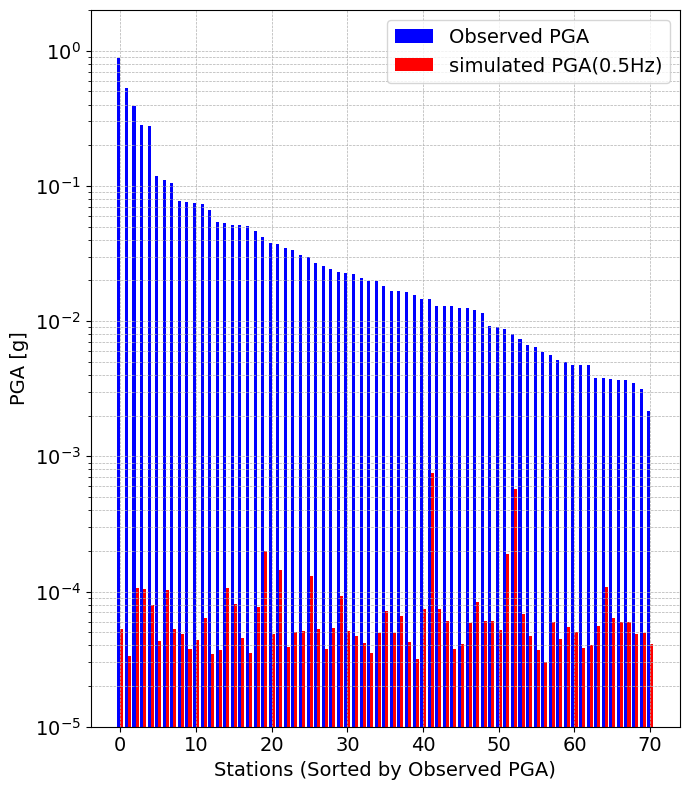

In [719]:
upper_bound = medianvec[10] * np.exp(sigma[10])
lower_bound = medianvec[10] * np.exp(-sigma[10])

# Observed and predicted PGA values
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = PGA1UD[indices] / (9.8 * 1e2)

# Combine Rjb and PGA values for sorting
combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T

# Sort by observed PGA values in descending order
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

# Extract sorted values
sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

# Set figure size
plt.figure(figsize=(7, 8))  # Adjust size as needed (width, height)

# Create bar chart
x = np.arange(len(sorted_rjb))  # Index for bars
plt.bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
plt.bar(x + 0.2, sorted_predicted_pga, width=0.4, label='simulated PGA(0.5Hz)', color='red')

# Set log scale for y-axis
plt.yscale('log')

# Add labels, legend, and title
plt.xlabel('Stations (Sorted by Observed PGA)', fontsize=14)
plt.ylabel('PGA [g]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.00001,2])
plt.tight_layout() 
# Save plot as PNG and PDF
# plt.savefig('pga_comparison_LF.png', dpi=300)  # Save as PNG
# plt.savefig('pga_comparison_LF.pdf', dpi=300)  # Save as PDF

# Show plot
plt.show()

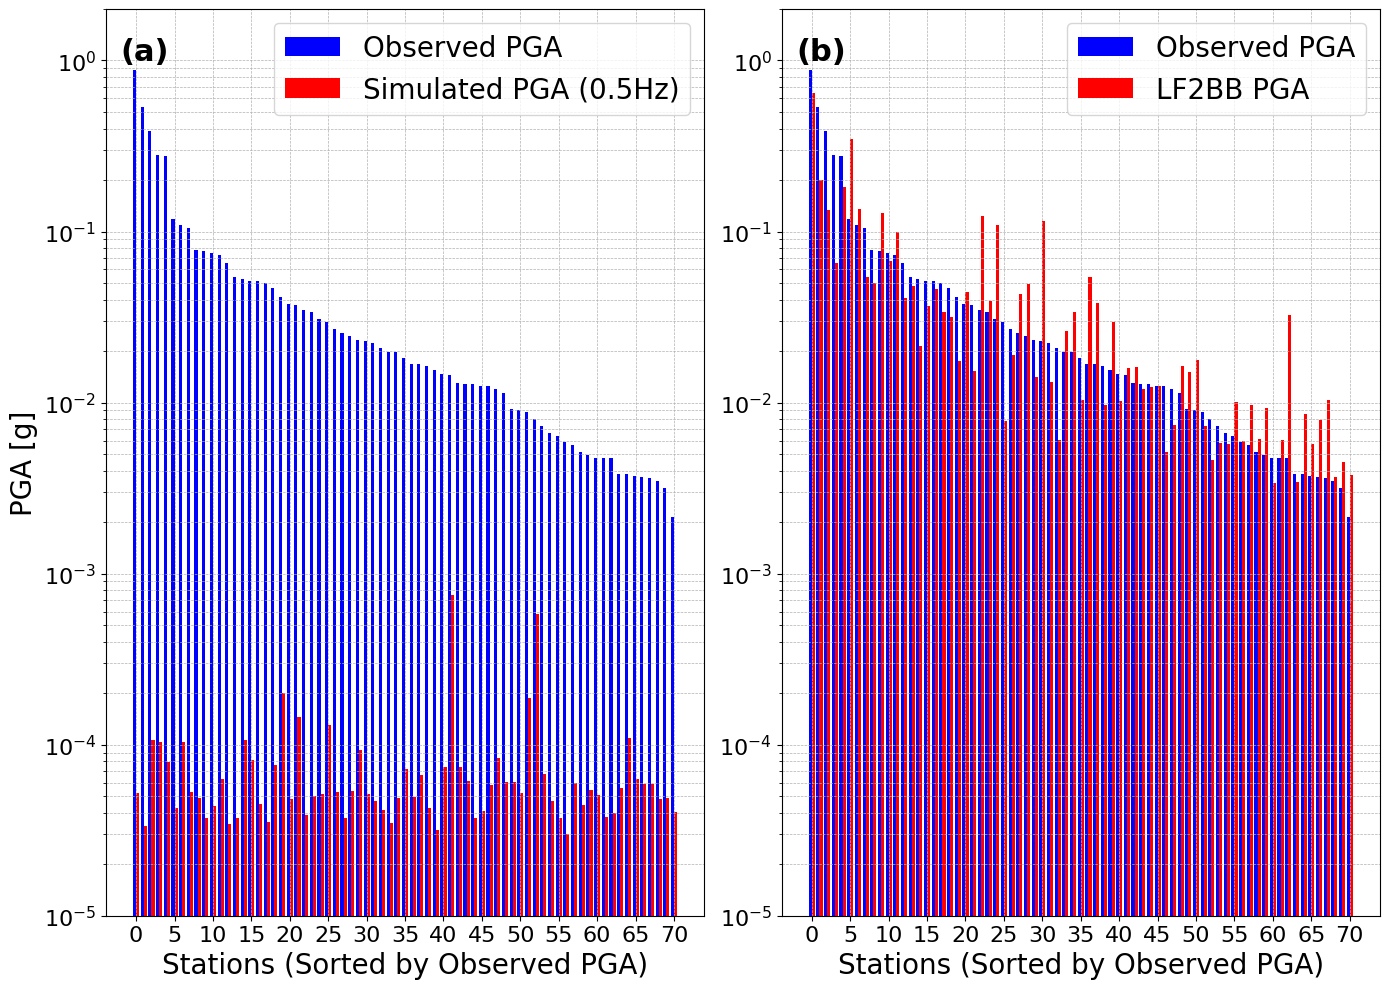

In [720]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data is already defined (e.g., medianvec, sigma, y_test, predictions, etc.)

# Set up the 2x1 figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))  # Adjusted for two subplots

# Set (a) plot
# Observed and predicted PGA values for the first plot
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = PGA1UD[indices] / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

x = np.arange(len(sorted_rjb))
axs[0].bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
axs[0].bar(x + 0.2, sorted_predicted_pga, width=0.4, label='Simulated PGA (0.5Hz)', color='red')

# (a) plot details
axs[0].set_yscale('log')
axs[0].set_xlabel('Stations (Sorted by Observed PGA)', fontsize=20)
axs[0].set_ylabel('PGA [g]', fontsize=20)
axs[0].legend(fontsize=20)
axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
axs[0].set_xticks(x[::5])  # Set x-ticks to the bar positions
axs[0].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])  # Custom y-ticks (log scale)
axs[0].set_ylim([0.00001, 2])
axs[0].text(-2, 1, '(a)', fontsize=22, fontweight='bold')
axs[0].tick_params(axis='both', labelsize=16)
# Set (b) plot
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = np.exp(predictions[indices, 0, ind]) / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

x = np.arange(len(sorted_rjb))
axs[1].bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
axs[1].bar(x + 0.2, sorted_predicted_pga, width=0.4, label='LF2BB PGA', color='red')

# (b) plot details
axs[1].set_yscale('log')
axs[1].set_xlabel('Stations (Sorted by Observed PGA)', fontsize=20)
# axs[1].set_ylabel('PGA [g]', fontsize=14)
axs[1].legend(fontsize=20)
axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
axs[1].set_xticks(x[::5])  # Set x-ticks to the bar positions
axs[1].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])  # Custom y-ticks (log scale)
axs[1].set_ylim([0.00001, 2])
axs[1].text(-2, 1, '(b)', fontsize=22, fontweight='bold')
axs[1].tick_params(axis='both', labelsize=16)
# Tight layout to prevent overlapping
plt.tight_layout()

# Save the plot as PNG and PDF
# plt.savefig('pga_comparison_ud.png', dpi=300)  # Save as PNG
# plt.savefig('pga_comparison_ud.pdf', dpi=300)  # Save as PDF

# Show the plot
plt.show()

In [721]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

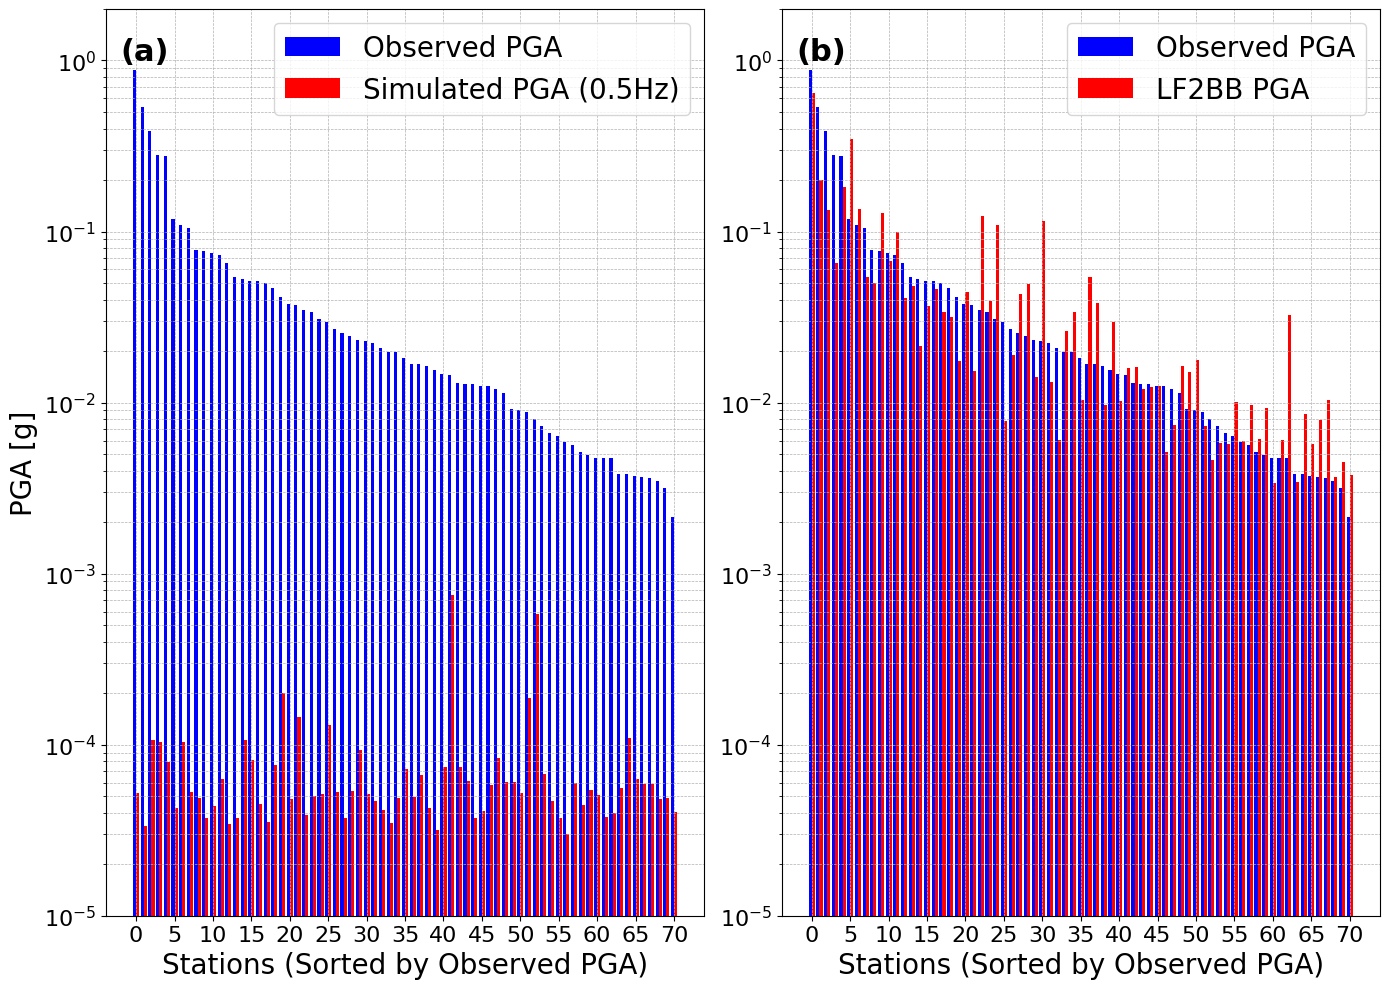

In [722]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data is already defined (e.g., medianvec, sigma, y_test, predictions, etc.)

# Set up the 2x1 figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))  # Adjusted for two subplots

# Set (a) plot
# Observed and predicted PGA values for the first plot
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = PGA1UD[indices] / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

x = np.arange(len(sorted_rjb))
axs[0].bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
axs[0].bar(x + 0.2, sorted_predicted_pga, width=0.4, label='Simulated PGA (0.5Hz)', color='red')

# (a) plot details
axs[0].set_yscale('log')
axs[0].set_xlabel('Stations (Sorted by Observed PGA)', fontsize=20)
axs[0].set_ylabel('PGA [g]', fontsize=20)
axs[0].legend(fontsize=20)
axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
axs[0].set_xticks(x[::5])  # Set x-ticks to the bar positions
axs[0].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])  # Custom y-ticks (log scale)
axs[0].set_ylim([0.00001, 2])
axs[0].text(-2, 1, '(a)', fontsize=22, fontweight='bold')
axs[0].tick_params(axis='both', labelsize=16)
# Set (b) plot
observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = np.exp(predictions[indices, 0, ind]) / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga = sorted_data[:, 2]

x = np.arange(len(sorted_rjb))
axs[1].bar(x - 0.2, sorted_observed_pga, width=0.4, label='Observed PGA', color='blue')
axs[1].bar(x + 0.2, sorted_predicted_pga, width=0.4, label='LF2BB PGA', color='red')

# (b) plot details
axs[1].set_yscale('log')
axs[1].set_xlabel('Stations (Sorted by Observed PGA)', fontsize=20)
# axs[1].set_ylabel('PGA [g]', fontsize=14)
axs[1].legend(fontsize=20)
axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
axs[1].set_xticks(x[::5])  # Set x-ticks to the bar positions
axs[1].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])  # Custom y-ticks (log scale)
axs[1].set_ylim([0.00001, 2])
axs[1].text(-2, 1, '(b)', fontsize=22, fontweight='bold')
axs[1].tick_params(axis='both', labelsize=16)
# Tight layout to prevent overlapping
plt.tight_layout()

# Save the plot as PNG and PDF
# plt.savefig('pga_comparison_ud.png', dpi=300)  # Save as PNG
# plt.savefig('pga_comparison_ud.pdf', dpi=300)  # Save as PDF

# Show the plot
plt.show()

In [723]:
# # 将原始数据按 rjb 从小到大排序
# combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
# sorted_data = combined_data[np.argsort(combined_data[:, 1])]  # 按 rjb 升序排列

# sorted_rjb = sorted_data[:, 0]
# sorted_observed_pga = sorted_data[:, 1]
# sorted_predicted_pga = sorted_data[:, 2]

# # 计算误差
# errors = (np.log10(sorted_observed_pga) - np.log10(sorted_predicted_pga)) / np.log10(sorted_predicted_pga)
# x = np.arange(len(sorted_rjb))

# # 绘图
# plt.figure(figsize=(14, 6))
# plt.bar(x, errors, width=0.6, color='salmon', edgecolor='black')
# plt.axhline(0, color='gray', linestyle='--')

# plt.xlabel('Stations (Sorted by Rjb)', fontsize=16)
# plt.ylabel('Relative Error (log10)', fontsize=16)
# plt.title('Relative Error Between Observed and Simulated PGA (Sorted by Rjb)', fontsize=18)
# plt.xticks(x[::5])
# plt.ylim([-1,1])
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

In [724]:
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
inx = 0
ind=2
observed_pga = np.exp(y_test[indices, inx, ind]) / (9.8 * 1e2)
predicted_pga = np.exp(predictions[indices, inx, ind]) / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga1 = sorted_data[:, 2]
corr_a, pval_a = pearsonr(sorted_observed_pga, sorted_predicted_pga1)
print(f"(a) Pearson correlation: {corr_a:.3f}, p-value: {pval_a:.3e}")

observed_pga = np.exp(y_test[indices, 0, ind]) / (9.8 * 1e2)
predicted_pga = PGA1UD[indices] / (9.8 * 1e2)

combined_data = np.vstack((rjb[indices].squeeze(), observed_pga, predicted_pga)).T
sorted_data = combined_data[np.argsort(-combined_data[:, 1])]

sorted_rjb = sorted_data[:, 0]
sorted_observed_pga = sorted_data[:, 1]
sorted_predicted_pga2 = sorted_data[:, 2]
corr_a, pval_a = pearsonr(sorted_observed_pga, sorted_predicted_pga2)
print(f"(a) Pearson correlation: {corr_a:.3f}, p-value: {pval_a:.3e}")

(a) Pearson correlation: 0.848, p-value: 9.796e-21
(a) Pearson correlation: -0.047, p-value: 6.979e-01


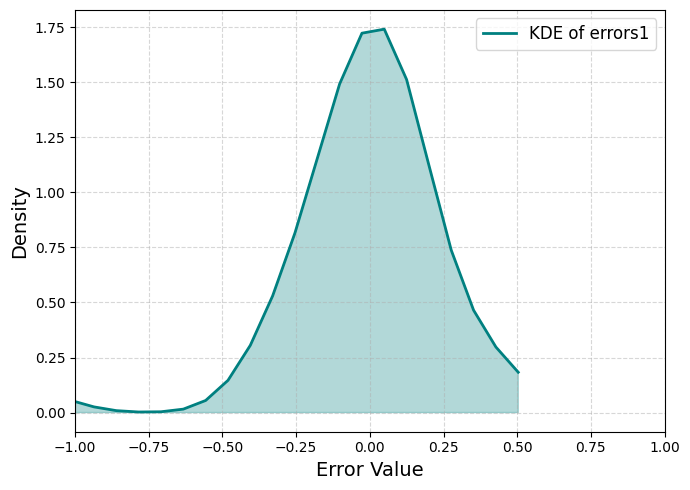

In [725]:
errors1 = (np.log10(sorted_observed_pga) - np.log10(sorted_predicted_pga1))/np.log10(sorted_observed_pga)
errors2 = (np.log10(sorted_observed_pga) - np.log10(sorted_predicted_pga2))/np.log10(sorted_observed_pga)

# errors1 = (np.log(sorted_observed_pga) - np.log(sorted_predicted_pga1))
# errors2 = (np.log(sorted_observed_pga) - np.log(sorted_predicted_pga2))

# errors1 =(sorted_observed_pga - sorted_predicted_pga1) / sorted_observed_pga
# errors2 = (sorted_observed_pga - sorted_predicted_pga2) / sorted_observed_pga

# Calculate MSE (for each station, one value)
mse_all1 = errors1
mse_all2 = errors2

# Calculate KDE for both errors
kde1 = gaussian_kde(errors1, bw_method=0.3)
kde2 = gaussian_kde(errors2, bw_method=0.3)

# Create a range of x values to evaluate the KDE
x = np.linspace(min(min(errors1), min(errors2)), max(max(errors1), max(errors2)), 1000)

# Plot the KDEs
fig, ax = plt.subplots(figsize=(7, 5))

# Plot and fill the area under KDE for errors1 and errors2
ax.fill_between(x, kde1(x), alpha=0.3, color='teal')  # Fill area under the KDE of errors1
# ax.fill_between(x, kde2(x), alpha=0.3, color='orange')  # Fill area under the KDE of errors2

# Plot the KDE curves on top
ax.plot(x, kde1(x), label="KDE of errors1", color='teal', linewidth=2)
# ax.plot(x, kde2(x), label="KDE of errors2", color='orange', linewidth=2)

# Add labels, legend, and grid
ax.set_xlabel("Error Value", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
plt.xlim([-1, 1])
plt.tight_layout()
plt.show()

In [726]:
# np.savetxt("/data_array1/panyx/ANN_GMPE/resnet_20240903/figure_forpaper/figure_bbresult_comp/yue_pred4_noratio.txt", np.column_stack((x, kde1(x))), header="Error_Value KDE_Density", fmt="%.6f")

# # 保存 errors1 的统计信息
# mean_err = np.mean(np.abs(errors1))
# std_err = np.std(errors1)
# np.savetxt(
#     "/data_array1/panyx/ANN_GMPE/resnet_20240903/figure_forpaper/figure_bbresult_correlation/hayes_pred_err_noratio.txt",
#     np.array([[mean_err, std_err, corr_a]]),
#     header="Mean_Error Std_Error",
#     fmt="%.6f"
# )

In [727]:
# observed_pga = np.exp(y_test[indices, 0, ind]) / ( 9.8*1e2)
# predicted_pga1 = PGA1UD[indices] / ( 9.8*1e2)
# predicted_pga2 = np.exp(predictions[indices, 0, ind]) / (  9.8*1e2)

In [728]:
# predicted_pga11 = np.log(PGA1UD[:])

observed_pga = np.log10(np.exp(y_test[:, 0, ind]))
predicted_pga1 = np.log10(PGA1UD[:])
predicted_pga2 = np.log10(np.exp(predictions[:, 0, ind]))

In [729]:
observed_pga.shape

torch.Size([71])

In [730]:
np.max(np.array(observed_pga))

2.9350283

In [731]:
# 计算比值
ratio1 = predicted_pga1 / observed_pga
ratio2 = predicted_pga2 / observed_pga

# 计算均值、最小值和最大值
mean_ratio1 = torch.mean(ratio1)
mean_ratio2 = torch.mean(ratio2)

min_ratio1 = torch.min(ratio1)
min_ratio2 = torch.min(ratio2)

max_ratio1 = torch.max(ratio1)
max_ratio2 = torch.max(ratio2)

# 打印结果
print("Mean Ratio 1:", mean_ratio1.item())
print("Mean Ratio 2:", mean_ratio2.item())
print("Min Ratio 1:", min_ratio1.item())
print("Min Ratio 2:", min_ratio2.item())
print("Max Ratio 1:", max_ratio1.item())
print("Max Ratio 2:", max_ratio2.item())

Mean Ratio 1: -1.1657602587941678
Mean Ratio 2: 1.0680073499679565
Min Ratio 1: -4.324219339244269
Min Ratio 2: 0.5901062488555908
Max Ratio 1: -0.11638086382774884
Max Ratio 2: 2.2649641036987305


In [732]:
observed_pga[5]

tensor(0.6643)

In [733]:
torch.argmax(ratio2).item()

5

In [734]:
mse_pga1 = torch.mean(abs((observed_pga - predicted_pga1))/observed_pga )


mse_pga2 = torch.mean(abs((observed_pga - predicted_pga2))/observed_pga )

# mse_pga1 = torch.mean((  predicted_pga1)/observed_pga)
# mse_pga2 = torch.mean(( predicted_pga2)/observed_pga)


print(f"MSE between observed_pga and predicted_pga1: {mse_pga1.item()}")
print(f"MSE between observed_pga and predicted_pga2: {mse_pga2.item()}")

MSE between observed_pga and predicted_pga1: 2.1657602573352706
MSE between observed_pga and predicted_pga2: 0.21917380392551422


In [735]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

Mean Absolute Error (MAE): 0.061119984835386276
Standard Deviation (sigma): 0.24115486443042755


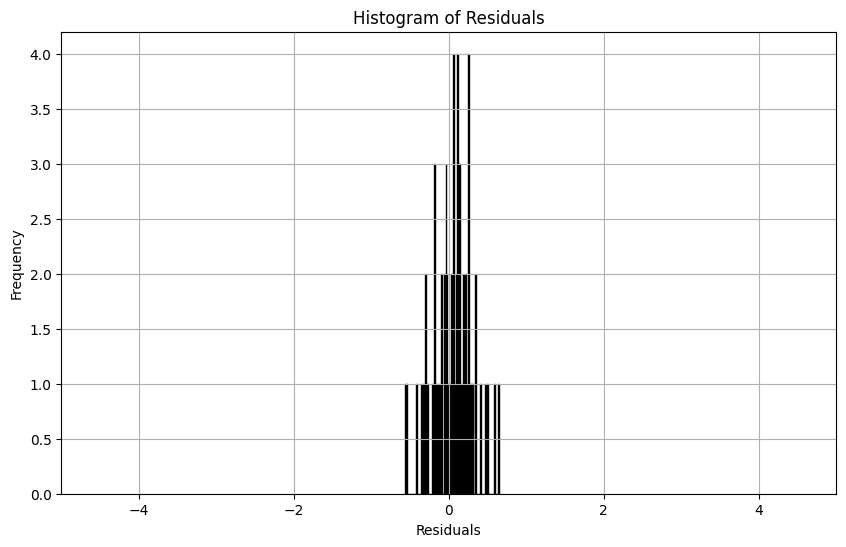

In [736]:
import numpy as np
import matplotlib.pyplot as plt
import torch
ind = 2
# y_testcpu = np.log10(np.exp(y_valid[:,0,ind].squeeze()))
# prediction1 = np.log10(np.exp(predictions[:,0,ind]))
y_testcpu = np.log10(np.exp((y_test[indices,11,ind].squeeze())))
prediction1 = np.log10(np.exp((predictions[indices,11,ind])))
# Assuming y_testcpu and prediction are your tensors
# Convert tensors to numpy arrays
y_testcpu_np = y_testcpu.cpu().numpy() if isinstance(y_testcpu, torch.Tensor) else y_testcpu
prediction_np1 = prediction.cpu().numpy() if isinstance(prediction1, torch.Tensor) else prediction1
# prediction_np2 = prediction.cpu().numpy() if isinstance(prediction2, torch.Tensor) else prediction2

# Calculate the residuals
# residuals = np.power(10, y_testcpu_np) - np.power(10, prediction_np)
residuals1 =  y_testcpu_np -prediction_np1
# residuals2 =  y_testcpu_np -prediction_np2
# Calculate MAE
mae1 = np.mean(np.abs(residuals1*residuals1))
# mae2 = np.mean(np.abs(residuals2*residuals2))
# Calculate sigma (standard deviation)
sigma1 = np.std(residuals1)
# sigma2 = np.std(residuals2)
# Print the results
print(f"Mean Absolute Error (MAE): {mae1}")
print(f"Standard Deviation (sigma): {sigma1}")
# print(f"Mean Absolute Error (MAE): {mae2}")
# print(f"Standard Deviation (sigma): {sigma2}")
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.xlim([-5, 5])
# plt.hist(residuals2, bins=100,  color='blue', edgecolor='k')
plt.hist(residuals1, bins=100,  color='red', edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


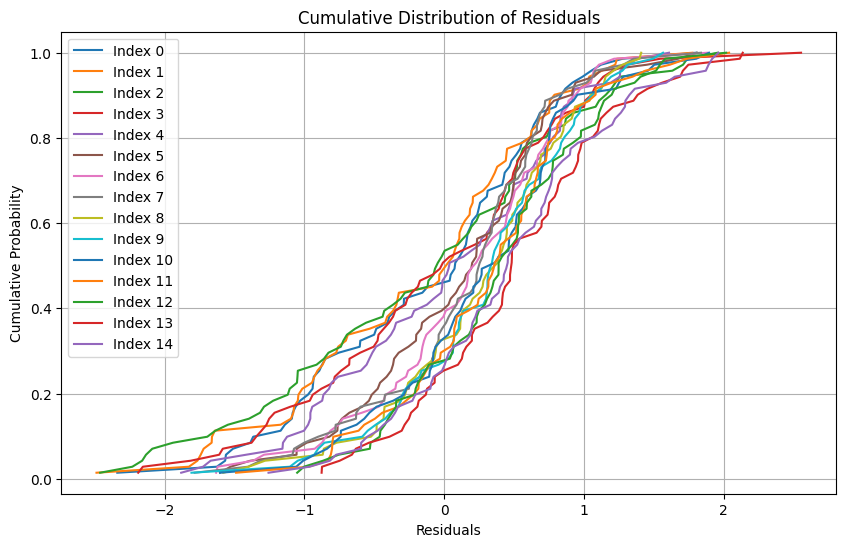

In [737]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 初始化索引变量
ind = 0

# 假设 y_test 和 predictions 已经是二维数组或张量

# 创建用于存储残差的空列表
residuals_all = []
mae_all = []
sigma_all = []
plt.figure(figsize=(10, 6))

# 对 y_test 的每一行进行循环
for i in range(y_test.shape[1]):
    # 获取当前行的 y_test 和 predictions 的值
    y_testcpu = y_test[indices, i, ind].squeeze()
    prediction1 = predictions[indices, i, ind]
    
    # 如果 y_testcpu 或 prediction1 是张量，则将它们转换为 NumPy 数组
    y_testcpu_np = y_testcpu.cpu().numpy() if isinstance(y_testcpu, torch.Tensor) else y_testcpu
    prediction_np1 = prediction1.cpu().numpy() if isinstance(prediction1, torch.Tensor) else prediction1
    
    # 计算残差
    residual = y_testcpu_np - prediction_np1
    
    sorted_residuals = np.sort(residual)
    cumulative = np.arange(1, len(sorted_residuals) + 1) / len(sorted_residuals)
    
    # 绘制每个残差的累积分布
    plt.plot(sorted_residuals, cumulative, label=f'Index {i}')

    mae = np.mean(np.abs(residual**2))
    sigma = np.std(residual)
    # 将残差添加到 residuals_all 列表中
    residuals_all.append(residual)
    mae_all.append(mae)
    sigma_all.append(sigma)

# 添加标题和标签
plt.title('Cumulative Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Cumulative Probability')
plt.grid(True)

# 添加图例
plt.legend()
plt.show()

In [738]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize index variable
ind = 2

# Assuming y_test and predictions are already defined as 2D arrays or tensors
# Create empty lists for storing residuals
residuals_all = []
mae_all = []
sigma_all = []

# Set a style
# plt.style.use('seaborn-darkgrid')

# Create a figure with a specific size


# Loop over each row of y_test
for i in range(y_test.shape[1]):
    # Get current row values for y_test and predictions
    y_testcpu = np.exp(y_test[indices, i, ind].squeeze())
    prediction1 = np.exp(predictions[indices, i, ind])
    
    # Convert tensors to NumPy arrays if needed
    y_testcpu_np = y_testcpu.cpu().numpy() if isinstance(y_testcpu, torch.Tensor) else y_testcpu
    prediction_np1 = prediction1.cpu().numpy() if isinstance(prediction1, torch.Tensor) else prediction1
    
    # Calculate residuals
    residual = np.log10(prediction_np1  / y_testcpu_np)
    
    # Store residuals
    residuals_all.append(residual)
    
    # Calculate MAE and standard deviation
    mae = np.mean(np.abs(residual**2))
    sigma = np.std(residual)
    
    mae_all.append(mae)
    sigma_all.append(sigma)

# Calculate mean and standard deviation of residuals
mean_residuals = [np.mean(residual) for residual in residuals_all]
std_residuals = [np.std(residual) for residual in residuals_all]

# Define indices for x-axis
T = np.arange(len(mean_residuals))  # Assuming T is the range of indices


In [739]:
T = np.concatenate( (np.arange(0.05, 0.1, 0.05) , np.arange (0.1, 1, 0.1)  , np.arange (1, 15.25, 0.25) ) ) # Time vector for the spectral response
T = np.concatenate((np.array([0]), T))

In [740]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [741]:
len(mean_residuals)

15

In [742]:
1/T[11]

1.0

In [743]:
std_residuals[:16]

[0.30018204,
 0.33792758,
 0.40577132,
 0.31595424,
 0.27521405,
 0.26786786,
 0.269765,
 0.26466677,
 0.22837245,
 0.22679609,
 0.24334514,
 0.24115486,
 0.25899258,
 0.29281348,
 0.28151715]

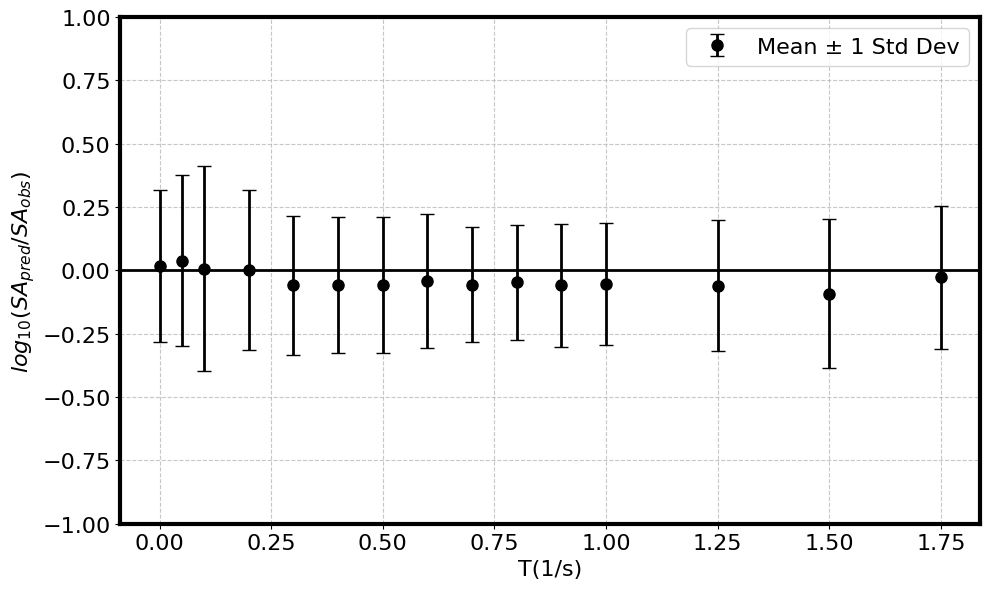

In [744]:
plt.figure(figsize=(10, 6))
# Use error bar plot for mean and standard deviation
# Use error bar plot for mean and standard deviation with black error bars
plt.errorbar(T[:15], mean_residuals[:15], yerr=std_residuals[:15], fmt='o',
             color='black', markersize=8,  label='Mean ± 1 Std Dev', 
             ecolor='black', elinewidth=2, capsize=5)

# Add a black line at y=0
plt.axhline(y=0, color='black', linewidth=2)

# Enhance plot aesthetics
plt.xlabel('T(1/s)', fontsize=16)
plt.ylabel('$log_{10}(SA_{pred}/SA_{obs})$', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines
plt.ylim([-1, 1])
plt.xticks(fontsize=16)  # Font size for x-ticks
plt.yticks(fontsize=16)  # Font size for y-ticks

# Add legend
plt.legend(fontsize=16)

# Increase border thickness
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)

plt.tight_layout()  # Adjust layout to prevent clipping
# plt.savefig('errorbar_0.5Hz_kumamoto_noagu.png',dpi=300)
plt.show()
# np.savetxt("/data_array1/panyx/ANN_GMPE/resnet_20240903/figure_forpaper/figure_bbresult_whole/residual_gp2.txt",
#            np.column_stack((T[:11], mean_residuals[:11], std_residuals[:11])),
#            header="Period Mean_Residual Std_Residual",
#            fmt="%.6f")

In [745]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [746]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [747]:
indices = np.where(dist < 10)[0]

In [748]:
pwd

'/data_array1/panyx/ANN_GMPE/resnet_20240903/pred_kumamoto_martin'

In [749]:
indices.shape

(2,)

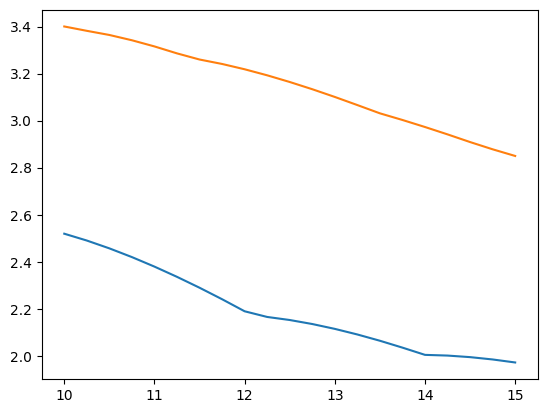

In [750]:
id=1
ic=0
plt.plot(T[47:],np.log(result_sim[indices[id],47:,ic]*100))
plt.plot(T[47:],np.log(result[indices[id],47:,ic]))

In [751]:
dist[indices[id]]

array([0.15481257])

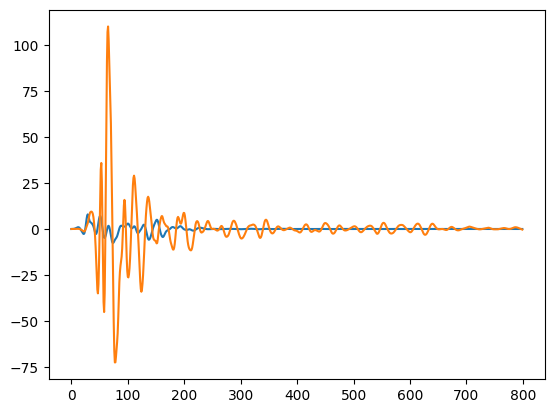

In [752]:
plt.plot(downsampled_data[indices[id],:,ic])
plt.plot(downsampled_databb[indices[id],:,ic])
# plt.savefig('dist015.png',dpi=300)